# Post Trade Analysis

Note: Please drag the SQLite file to the folder where you ran this notebook.

Read 1 trades from order_fill table.
Read 1 trades from order_fill table.


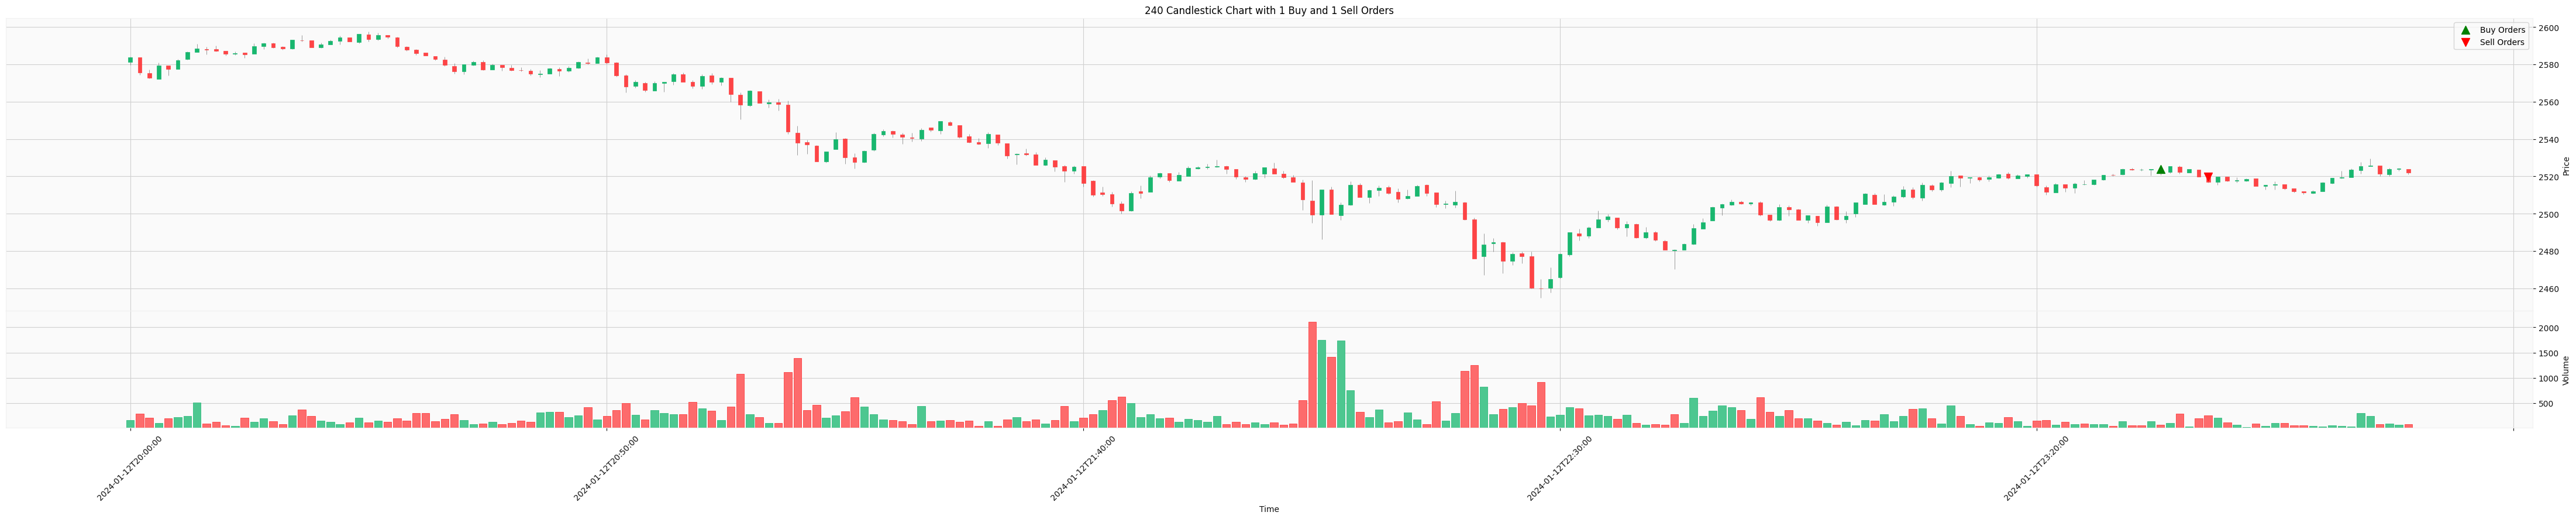

In [139]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import sqlite3

def table_exists(conn: sqlite3.Connection, table_name: str)-> bool:        
    # SQL query to check if the table exists
    query = f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';"
    
    # Execute the query
    query_result = pd.read_sql_query(query, conn)
    return len(query_result) > 0


def get_trades(conn: sqlite3.Connection, table_name: str, market_side: str, needs_rounding: bool = True) -> pd.DataFrame:
    if table_exists(conn, table_name):
        trades_df = pd.read_sql(f"select * from {table_name} where side='{market_side.upper()}'",
                         con=conn)
        trades_df["transaction_time"] = pd.to_datetime(trades_df["transaction_time"])                              
        if needs_rounding:                                 
            trades_df["transaction_time"] = trades_df["transaction_time"].dt.round("1min")
        trades_df.set_index('transaction_time', inplace=True)
        
        print(f"Read {len(trades_df)} trades from {table_name} table.")
        return trades_df
    
    print(f"Read 0 trades from {table_name} table.")
    return pd.DataFrame()


def plot_trades(database_name: str):    
    # Database connection
    conn = sqlite3.connect(database_name)

    # Read candlesticks from database
    df_candlesticks = pd.read_sql("select * from calculated_candlestick_feed", con=conn)
    df_candlesticks["start_time"] = pd.to_datetime(df_candlesticks["start_time"], format="%Y-%m-%d %H:%M:%S%z")
    df_candlesticks["end_time"] = pd.to_datetime(df_candlesticks["end_time"], format="%Y-%m-%d %H:%M:%S%z")
    df_candlesticks.set_index('start_time', inplace=True)
    df_candlesticks.sort_index(ascending=True, inplace=True)

    # Additional plots to draw buy orders with green triangles and sell orders with red triangles
    add_plots = []

    # Read buy orders from database
    buy_orders_df = get_trades(conn, "order_fill", "buy")
    if len(buy_orders_df) > 0:
        buy_orders_df = buy_orders_df.reindex(df_candlesticks.index, axis='index', fill_value=np.NaN)
        add_plots.append(mpf.make_addplot(buy_orders_df['price'], 
                                          type='scatter', markersize=100, 
                                          marker='^', color='g', label='Buy Orders'))

    # Read sell orders from database
    sell_orders_df = get_trades(conn, "order_fill", "sell")
    if len(sell_orders_df) > 0:
        sell_orders_df = sell_orders_df.reindex(df_candlesticks.index, axis='index', fill_value=np.NaN)
        add_plots.append(mpf.make_addplot(sell_orders_df['price'], 
                                          type='scatter', markersize=100, 
                                          marker='v', color='r', label='Sell Orders'))
    
    # Plot candlestick chart
    mpf.plot(df_candlesticks, 
             type='candle', 
             volume=True,
             style='yahoo', 
             axtitle=f'{len(df_candlesticks)} Candlestick Chart with {len(buy_orders_df.dropna())} Buy and {len(sell_orders_df.dropna())} Sell Orders', 
             xlabel="Time",
             ylabel='Price', 
             figsize=(60, 10),
             datetime_format='%Y-%m-%dT%H:%M:%S',
             addplot=add_plots
    )
    
plot_trades('crypto.sqlite')

In [138]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import sqlite3


def plotly_trades(database_name: str):    
    # Database connection
    conn = sqlite3.connect(database_name)

    # Read candlesticks from database
    df_candlesticks = pd.read_sql("select * from calculated_candlestick_feed", con=conn)
    df_candlesticks["start_time"] = pd.to_datetime(df_candlesticks["start_time"], format="%Y-%m-%d %H:%M:%S%z")
    df_candlesticks["end_time"] = pd.to_datetime(df_candlesticks["end_time"], format="%Y-%m-%d %H:%M:%S%z")
    df_candlesticks["bullish"] = (df_candlesticks['close'] > df_candlesticks['open']).astype(int)
    df_candlesticks.set_index('start_time', inplace=True)
    df_candlesticks.sort_index(ascending=True, inplace=True)

    # Read buy orders from database
    buy_orders_df = get_trades(conn, "order_fill", "buy", needs_rounding=False)

    # Read sell orders from database
    sell_orders_df = get_trades(conn, "order_fill", "sell", needs_rounding=False)
    
    buy_markers = go.Scatter(
        x=buy_orders_df.index,
        y=buy_orders_df['price'],
        mode='markers',
        marker=dict(color='cyan', size=10, symbol='triangle-up'),
        name='Buy Orders'
    )
    
    sell_markers = go.Scatter(
        x=sell_orders_df.index,
        y=sell_orders_df['price'],
        mode='markers',
        marker=dict(color='purple', size=10, symbol='triangle-down'),
        name='Sell Orders'
    )

    # Create volume bar trace
    volume_colors = df_candlesticks["bullish"].apply(lambda x: "rgba(0, 200, 0, 0.1)" if x == 1 else "rgba(200, 0, 0, 0.1)").to_list()
    volume_trace = go.Bar(
        x=df_candlesticks.index,
        y=df_candlesticks['volume'],
        yaxis='y2',  # Use secondary y-axis for volume
        marker=dict(
            color=volume_colors
        ),
        name='Volume',
        hoverinfo='skip'
    )

    layout = go.Layout(
        title=f'{len(df_candlesticks)} Candlestick Chart with {len(buy_orders_df.dropna())} Buy and {len(sell_orders_df.dropna())} Sell Orders', 
        xaxis=dict(title='Date (UTC)'),
        yaxis=dict(title='Price (Dollars)'),
        yaxis2=dict(title='Volume', overlaying='y', side='right')
    )

    # Plot candlestick chart
    fig = go.Figure(data=[
        volume_trace,
        go.Candlestick(x=df_candlesticks.index, # date values
                       open=df_candlesticks['open'],
                       high=df_candlesticks['high'],
                       low=df_candlesticks['low'],
                       close=df_candlesticks['close'],
                       name='Candlestick'
        ),
        buy_markers,
        sell_markers
    ], layout=layout)
    
    # Set layout size
    fig.update_layout(
        xaxis_rangeslider_visible=True, 
        autosize=False,
        width=4000,
        height=600)
    fig.show()

plotly_trades('crypto.sqlite')

Read 3 trades from order_fill table.
Read 3 trades from order_fill table.
